<a href="https://colab.research.google.com/github/vilcagamarracf/Inv_arroz_METRIC/blob/main/Inv_Arroz_METRIC_Pruebas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pruebas (Google Colab)

#### Inicio

##### Credenciales

In [1]:
# # Ingresa tus credenciales de Google Earth Engine para comenzar
# import ee
# ee.Authenticate()

# # Inicio
# ee.Initialize()

# # Mensaje de login
# print('\nYa estás logeado.')
# print('GEE Version:', ee.__version__)

In [2]:
#@markdown *Credenciales Google Earth Engine: Forma rápida*
import os 
credential = '{"refresh_token":"1//09lhqedCNpNDsCgYIARAAGAkSNwF-L9IraEP8FyJma46WSiEHhOMsZqSoTPJsi3Lar0C4nZUwj2QCZ_i66-McVzy4NmMalQL17KM"}'
credential_file_path = os.path.expanduser("~/.config/earthengine/")
os.makedirs(credential_file_path,exist_ok=True)
with open(credential_file_path + 'credentials', 'w') as file:
    file.write(credential)
import ee
ee.Initialize()
print('Ya estás logeado.')
print('GEE Version:',ee.__version__)

Ya estás logeado.
GEE Version: 0.1.290


##### geemap

In [3]:
# Instalar geemap
%%capture
!pip install -U geemap # Nota: Con la actualización de ipyleaflet v0.15.0 se produjo un conflicto con geemap
# !pip install geemap==0.10.1

Documentación `geemap`
- [geemap - key features](https://geemap.org/notebooks/00_geemap_key_features/)

In [4]:
# Interfaz interactiva con geemap 
import geemap
# import geemap.eefolium as geemap
Map = geemap.Map(basemap='HYBRID', center=(-9.125, -74.396), zoom=5) # basemap='HYBRID', 
# Map = geemap.Map(basemap='OpenStreetMap.Mapnik', center=(-9.125, -74.396), zoom=5) # Para visualización minimalista
# Map

##### Funciones específicas

In [5]:
# Mejorar visibilidad de tablas en Colab
%load_ext google.colab.data_table

# Para volver al estado original de las tablas
# %unload_ext google.colab.data_table

In [6]:
# Funciones usadas en Inv-Arroz-METRIC

import ee
import geemap
import pandas as pd
from ipywidgets import interact, fixed

import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates # Modificar fechas por formato
date_format = mpl_dates.DateFormatter('%Y-%m')

In [103]:
# @markdown Función `generar_reporte(icol)`

def generar_reporte(icol):
  """Generar reportes para ee.ImageCollection 's
  
  A partir de un ee.ImageCollection devolver una tabla 
  con información de ID, Fechas (Año, Mes, Día, Día Juliano) y 
  propiedades como Ángulo Zenital y Porcentaje de Nubosidad.

  Argumentos:
  - icol : ee.ImageCollection
  Retorna:
  - pandas.Dataframe
  """
  ## Generando campos para la tabla
  ID_snippet_name = icol.getInfo()['id']

  # Lista con fechas (en milisegundos)
  lista_fechas = icol.aggregate_array('system:time_start').getInfo() # Fechas
  # Lista con ID's
  imgCol_ids = [f'{ID_snippet_name}/{i}' for i in icol.aggregate_array("system:index").getInfo()] # ID

  # Armando dataframe
  df = pd.DataFrame(lista_fechas, columns = ['millis'])

  df["ID GEE"] = imgCol_ids
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Fecha Precisa'] = pd.DatetimeIndex(df['Timestamp']) # Con hora
  # df['Fecha Corta'] = pd.DatetimeIndex(df['Timestamp']).date
  df['Año'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Mes'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Día'] = pd.DatetimeIndex(df['Timestamp']).day
  # df['Hora'] = pd.DatetimeIndex(df['Timestamp']).hour
  df['Día Juliano'] = pd.DatetimeIndex(df['Timestamp']).dayofyear

  # Agregando propiedades
  if ID_snippet_name == 'LANDSAT/LC08/C01/T1_SR':
    df['SOLAR_ZENITH_ANGLE'] = icol.aggregate_array('SOLAR_ZENITH_ANGLE').getInfo()
    df['CLOUD_COVER'] = icol.aggregate_array('CLOUD_COVER').getInfo()

  elif ID_snippet_name == 'LANDSAT/LC08/C02/T1_L2':
    df['CLOUD_COVER'] = icol.aggregate_array('CLOUD_COVER').getInfo()
    df['SUN_ELEVATION'] = icol.aggregate_array('SUN_ELEVATION').getInfo()
    df['ZENITH ANGLE'] = 90. - df['SUN_ELEVATION']
    df['ZENITH ANGLE'] = df['ZENITH ANGLE'].round(decimals=7)
    df = df.drop(columns=['SUN_ELEVATION'])

  elif ID_snippet_name == 'COPERNICUS/S2_SR':
    df['MEAN_SOLAR_ZENITH_ANGLE'] = icol.aggregate_array('MEAN_SOLAR_ZENITH_ANGLE').getInfo()
    df['CLOUDY_PIXEL_PERCENTAGE'] = icol.aggregate_array('CLOUDY_PIXEL_PERCENTAGE').getInfo()
  
  df = df.drop(columns=['millis', 'Timestamp'])
  # df.to_csv('datos_2020_L8_SR.csv')
  
  return df

In [8]:
# @markdown Función `ver_imgs_mensual(mes, df, roi, mask=None)`
def ver_imgs_mensual(mes, df, roi, mask=None):
  """Visualizar imágenes a partir del reporte generado con la función generar_reporte
  
  Argumentos:
  - mes : lista de valores [1,2,3] del 1 al 12 que representen los meses
  - df : pandas.DataFrame con columna 'ID GEE' de ID's 
  - roi : ee.geometry o ee.FeatureCollection 
  Retorna:
  - ee.Image

  Usarse con interact
  """
  # Del dataframe obtenemos las imagenes de acuerdo al mes que queramos
  lista_imagenes = df[df['Mes'] == mes]['ID GEE'].tolist()

  # Parametros de visualización RGB
  vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']}
  # 'gamma':1.4
  
  # geemap para la visualización
  # import geemap.eefolium as geemap
  Map = geemap.Map(layer_ctrl=True) # basemap='OpenStreetMap.Mapnik', 
  Map.centerObject(roi, 12)  # Map.setCenter(-79.809, -6.746, 9)
  if lista_imagenes[0][:4] == 'COPE':
    if mask != True:
      for i in lista_imagenes:                   
        Map.addLayer(ee.Image(i).multiply(0.0001), vis_rgb, f'Imagen {i[21:23]}/{i[23:25]}')
      # Visualizar al último el ROI
      Map.addLayer(roi, {'color':'00FF00'}, 'ROI')
    else:
      # Visualizar primero el ROI
      Map.addLayer(roi, {'color':'00FF00'}, 'ROI')
      for i in lista_imagenes:                   
        Map.addLayer(maskS2clouds(ee.Image(i)).multiply(0.0001), vis_rgb, f'Imagen {i[21:23]}/{i[23:25]}') 
  else:
    for i in lista_imagenes:
      Map.addLayer(ee.Image(i).multiply(0.0001), vis_rgb, f'Imagen {i[-4:-2]}/{i[-2:]}')
      
  return Map

In [9]:
# @markdown Función `maskS2clouds(image)` para enmascarar nubes en imágenes Sentinel-2

## Operadores de bit a bit
# Operador bit a bit desplazamiento a la izquierda <<
# Little indian (los bits se cuentan de izq a derecha) y Big indian (los bits se cuentan de derecha a izq)
def maskS2clouds(image):
  qa = image.select('QA60')
  opaque_cloud = 1 << 10
  cirrus_cloud = 1 << 11
  mask = (
      qa.bitwiseAnd(opaque_cloud).eq(0)
      .And(qa.bitwiseAnd(cirrus_cloud).eq(0))
  )
  clean_image = (
      image.updateMask(mask)
      .divide(10000)
      .copyProperties(image, ["system:time_start"])
  )
  return clean_image

## Visualizaciones

### Distrito de Chongoyape

Assets personales con datos vectoriales provistos por el Instituto Geográfico Nacional (IGN) de manera [pública](https://www.idep.gob.pe/#visor):
- Departamentos: `'users/CesarVilca/departamentos'`
- Provincias: `'users/CesarVilca/provincias'`
- Distritos: `'users/CesarVilca/distritos'`

In [10]:
# Ejemplo de filtrado

# Assets
asset_departamentos = ee.FeatureCollection('users/CesarVilca/departamentos')
asset_provincias = ee.FeatureCollection('users/CesarVilca/provincias')
asset_distritos = ee.FeatureCollection('users/CesarVilca/distritos')

# Filtrado
lambayeque = asset_departamentos.filterMetadata('DEPARTAMEN','equals','LAMBAYEQUE')
chiclayo = asset_provincias.filterMetadata('PROVINCIA','equals','CHICLAYO')
chongoyape = asset_distritos.filterMetadata('DISTRITO','equals','CHONGOYAPE')

# Zona de evaluación
parcelas_chongoyape = ee.FeatureCollection("users/CesarVilca/parcelas_chongoyape")

In [11]:
# @markdown Visualización con `geemap`: Distrito de Chongoyape

# Visualización
LambayequeDraw = lambayeque.draw(color = "D8EED0", strokeWidth = 1, pointRadius = 2) 
ChiclayoDraw = chiclayo.draw(color = "00FF00", strokeWidth = 1, pointRadius = 2) 
ChongoyapeDraw = chongoyape.draw(color = "00FFFF", strokeWidth = 1, pointRadius = 2) 
parcelasDraw = parcelas_chongoyape.draw(color = "0000FF", strokeWidth = 1, pointRadius = 2) 

# Punto
chongoyape_punto = ee.Geometry.Point([-79.389, -6.639])

Map = geemap.Map(basemap='HYBRID', layer_ctrl=True) # OpenStreetMap.Mapnik
Map.centerObject(parcelas_chongoyape, 11) # Map.setCenter(lon, lat, zoom)
Map.addLayer(LambayequeDraw, {}, name = 'Lambayeque')
Map.addLayer(ChiclayoDraw, {}, name = 'Chiclayo')
Map.addLayer(ChongoyapeDraw, {}, name = 'Chongoyape')
Map.addLayer(parcelasDraw, {}, name = 'Parcelas Chongoyape')

Map

Map(center=[-6.612570768066261, -79.39809118558777], controls=(WidgetControl(options=['position', 'transparent…

### Landsat 8

###### USGS Landsat 8 Surface Reflectance Tier 1 [deprecated] - [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR)

In [92]:
# Filtrado Landsat 8
snippet_name = "LANDSAT/LC08/C01/T1_SR"
path = 10
row = 65
year = 2021
roi = chongoyape_punto

icol_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
    .filterBounds(roi)
)

In [93]:
dfl8 = generar_reporte(icol_sr)
dfl8

,ID GEE,Fecha Precisa,Año,Mes,Día,Día Juliano,SOLAR_ZENITH_ANGLE,CLOUD_COVER
0,LANDSAT/LC08/C01/T1_SR/LC08_010065_20210102,2021-01-02 15:28:34.101,2021,1,2,2,31.894131,40.61
1,LANDSAT/LC08/C01/T1_SR/LC08_010065_20210203,2021-02-03 15:28:25.244,2021,2,3,34,31.967308,2.62
2,LANDSAT/LC08/C01/T1_SR/LC08_010065_20210307,2021-03-07 15:28:13.534,2021,3,7,66,30.574303,35.30
3,LANDSAT/LC08/C01/T1_SR/LC08_010065_20210323,2021-03-23 15:28:06.322,2021,3,23,82,30.729298,11.67
4,LANDSAT/LC08/C01/T1_SR/LC08_010065_20210408,2021-04-08 15:28:01.927,2021,4,8,98,31.944176,48.31
5,LANDSAT/LC08/C01/T1_SR/LC08_010065_20210424,2021-04-24 15:27:54.495,2021,4,24,114,34.098743,28.75
6,LANDSAT/LC08/C01/T1_SR/LC08_010065_20210510,2021-05-10 15:27:49.775,2021,5,10,130,36.695053,9.94
7,LANDSAT/LC08/C01/T1_SR/LC08_010065_20210526,2021-05-26 15:27:59.826,2021,5,26,146,39.111782,88.94
8,LANDSAT/LC08/C01/T1_SR/LC08_010065_20210611,2021-06-11 15:28:06.858,2021,6,11,162,40.849697,97.44
9,LANDSAT/LC08/C01/T1_SR/LC08_010065_20210627,2021-06-27 15:28:11.059,2021,6,27,178,41.507404,88.26


In [85]:
mes = dfl8['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, df=fixed(dfl8), roi=fixed(chongoyape), mask=fixed(None));

interactive(children=(Dropdown(description='mes', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Output())…

Arroz - Campañas de siembra a cosecha: **Agosto a Diciembre**

Imágenes libre de nubes:
- Agosto: 14, 30 (revisar)
- Setiembre: 15
- Octubre: 1, 17 (Nublado)
- Noviembre: No hay imágenes


###### USGS Landsat 8 Level 2, Collection 2, Tier 1 - [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2)

In [104]:
ID_snippet_name = "LANDSAT/LC08/C02/T1_L2"
path = 10
row = 65
year = 2021

## Filtrado de ee.imageCollection
icol_sr = (
    ee.ImageCollection(ID_snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

In [105]:
reporteL8_C2 = generar_reporte(icol_sr)
reporteL8_C2

,ID GEE,Fecha Precisa,Año,Mes,Día,Día Juliano,CLOUD_COVER,ZENITH ANGLE
0,LANDSAT/LC08/C02/T1_L2/LC08_010065_20210102,2021-01-02 15:28:34.101,2021,1,2,2,40.75,31.894129
1,LANDSAT/LC08/C02/T1_L2/LC08_010065_20210203,2021-02-03 15:28:25.244,2021,2,3,34,2.66,31.967307
2,LANDSAT/LC08/C02/T1_L2/LC08_010065_20210307,2021-03-07 15:28:13.534,2021,3,7,66,35.54,30.574302
3,LANDSAT/LC08/C02/T1_L2/LC08_010065_20210323,2021-03-23 15:28:06.322,2021,3,23,82,11.74,30.729299
4,LANDSAT/LC08/C02/T1_L2/LC08_010065_20210408,2021-04-08 15:28:01.927,2021,4,8,98,48.35,31.944175
5,LANDSAT/LC08/C02/T1_L2/LC08_010065_20210424,2021-04-24 15:27:54.495,2021,4,24,114,28.81,34.098745
6,LANDSAT/LC08/C02/T1_L2/LC08_010065_20210510,2021-05-10 15:27:49.775,2021,5,10,130,9.97,36.695052
7,LANDSAT/LC08/C02/T1_L2/LC08_010065_20210526,2021-05-26 15:27:59.826,2021,5,26,146,88.96,39.111781
8,LANDSAT/LC08/C02/T1_L2/LC08_010065_20210611,2021-06-11 15:28:06.858,2021,6,11,162,97.46,40.849695
9,LANDSAT/LC08/C02/T1_L2/LC08_010065_20210627,2021-06-27 15:28:11.059,2021,6,27,178,88.29,41.507404


In [ ]:
# @markdown Visualizar imágenes de Landsat8 L2
def visualizar_mes_L8_L2(mes, df, roi):
  
  # Del dataframe obtenemos las imagenes de acuerdo al mes que queramos
  lista_imagenes = df[df['Mes'] == mes]['ID GEE'].tolist()

  # Parametros de visualización RGB, 'gamma':1.4
  vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']}
  
  # geemap para la visualización
  # import geemap.eefolium as geemap
  Map = geemap.Map(layer_ctrl=True) # basemap='OpenStreetMap.Mapnik', 
  Map.centerObject(roi, 12)  # Map.setCenter(-79.809, -6.746, 9)
  for i in lista_imagenes:
    Map.addLayer(
        ee.Image(i).multiply(0.0000275).add(-0.2), vis_rgb, f'Imagen {i[-4:-2]}/{i[-2:]}')

  return Map

In [ ]:
mes = reporteL8_C2['Mes'].unique().tolist()
interact(visualizar_mes_L8_L2, mes=mes, df=fixed(reporteL8_C2), roi=fixed(chongoyape));

interactive(children=(Dropdown(description='mes', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), value=1), Outpu…

Arroz - Campañas de siembra a cosecha: **Agosto a Diciembre**

Imágenes libre de nubes:
- Agosto: 14, 30 (revisar)
- Setiembre: 15
- Octubre: 1, 17 (Nublado)
- Noviembre: 2 y 18


### Sentinel-2

In [ ]:
# Filtrado Sentinel-2
snippet_name = 'COPERNICUS/S2_SR'
year = 2021
roi = chongoyape_punto

icol_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterBounds(roi)
)

In [ ]:
dfs2 = generar_reporte(icol_sr)
dfs2

,ID GEE,Fecha Precisa,Año,Mes,Día,Día Juliano,Zenith Angle,Porcentaje Nubes (%)
0,COPERNICUS/S2_SR/20210101T153619_20210101T1544...,2021-01-01 15:45:05.914,2021,1,1,1,28.362474,60.175373
1,COPERNICUS/S2_SR/20210106T153621_20210106T1540...,2021-01-06 15:45:08.039,2021,1,6,6,28.540159,96.552039
2,COPERNICUS/S2_SR/20210111T153619_20210111T1537...,2021-01-11 15:45:06.966,2021,1,11,11,28.625081,14.484162
3,COPERNICUS/S2_SR/20210116T153621_20210116T1540...,2021-01-16 15:45:08.324,2021,1,16,16,28.601828,92.622773
4,COPERNICUS/S2_SR/20210121T153619_20210121T1537...,2021-01-21 15:45:07.362,2021,1,21,21,28.493682,27.849255
...,...,...,...,...,...,...,...,...
64,COPERNICUS/S2_SR/20211112T153621_20211112T1540...,2021-11-12 15:45:09.353,2021,11,12,316,21.862431,9.316200
65,COPERNICUS/S2_SR/20211117T153619_20211117T1537...,2021-11-17 15:45:05.511,2021,11,17,321,22.667283,12.258994
66,COPERNICUS/S2_SR/20211122T153621_20211122T1540...,2021-11-22 15:45:07.596,2021,11,22,326,23.482486,31.135298
67,COPERNICUS/S2_SR/20211127T153619_20211127T1537...,2021-11-27 15:45:03.072,2021,11,27,331,24.320940,15.195945


Arroz - Campañas de siembra a cosecha: **Agosto a Diciembre**

Imágenes libre de nubes:
- Agosto: 9, 14, 19, 24
- Setiembre: 3, 13, 18 (problema de corte), 28
- Octubre: 23 y 28
- Noviembre: 2, 7, 17, 22 y 27
- Diciembre: 2


In [ ]:
mes = dfs2['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, df=fixed(dfs2), roi=fixed(parcelas_chongoyape), mask=[True, None]);

interactive(children=(Dropdown(description='mes', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=1), D…

### Indices de Vegetación

#### Previo
- Funciones
- Paletas de colores
- Visualizador de índices

In [ ]:
# @markdown Indices de Vegetación:
# @markdown - Función NDVI: `ndvi_icol(image)`
# @markdown - Función EVI: `evi_icol(img)`

def ndvi_icol(image):
  ndvi = image.expression(
      '(nir - red) / (nir + red)',
      {'red' : image.select('B4').divide(10000),
       'nir' : image.select('B8').divide(10000)}).rename('NDVI')
  return image.addBands(ndvi)

# def ndvi_icol(image):
#   ndvi = image.normalizedDifference(['B8','B4']).rename('ndvi')
#   return image.addBands([ndvi])


def evi_icol(image):
  """
  https://developers.google.com/earth-engine/guides/image_math#expressions
  """
  evi = image.expression('2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)',
                       {'red' : image.select('B4').divide(10000),
                        'nir' : image.select('B8').divide(10000),
                        'blue': image.select('B2').divide(10000)}).rename('EVI')

  return image.addBands(evi)

In [ ]:
# @markdown Paletas de colores para NDVI y EVI

#------------- Paletas de NDVI ---------------------------------------
# @markdown - `BWG` : Blue, White, Green para valores -1 a 1
BWG = ['blue', 'white', 'green']

# @markdown - `GIMMS_NDVI` : GIMMS NDVI From AVHRR Sensors (3rd Generation)
# https://developers.google.com/earth-engine/datasets/catalog/NASA_GIMMS_3GV0?hl=en
GIMMS_NDVI = ['000000', 'f5f5f5', '119701']

# @markdown - `MOD13A1` : MOD13A1.006 Terra Vegetation Indices 16-Day Global 500m
# https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13A1?hl=en#description
MOD13A1 = [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301'
]

# @markdown - `yuri_ndvi_pal` : Paleta NDVI (Yuri SIG) 20 Colores
yuri_ndvi_pal = [
    'ffffff', 'fffcff', 'fff9ff', 'fff7ff', 'fff4ff', 'fff2ff', 'ffefff',
    'ffecff', 'ffeaff', 'ffe7ff', 'ffe5ff', 'ffe2ff', 'ffe0ff', 'ffddff',
    'ffdaff', 'ffd8ff', 'ffd5ff', 'ffd3ff', 'ffd0ff', 'ffceff', 'ffcbff',
    'ffc8ff', 'ffc6ff', 'ffc3ff', 'ffc1ff', 'ffbeff', 'ffbcff', 'ffb9ff',
    'ffb6ff', 'ffb4ff', 'ffb1ff', 'ffafff', 'ffacff', 'ffaaff', 'ffa7ff',
    'ffa4ff', 'ffa2ff', 'ff9fff', 'ff9dff', 'ff9aff', 'ff97ff', 'ff95ff',
    'ff92ff', 'ff90ff', 'ff8dff', 'ff8bff', 'ff88ff', 'ff85ff', 'ff83ff',
    'ff80ff', 'ff7eff', 'ff7bff', 'ff79ff', 'ff76ff', 'ff73ff', 'ff71ff',
    'ff6eff', 'ff6cff', 'ff69ff', 'ff67ff', 'ff64ff', 'ff61ff', 'ff5fff',
    'ff5cff', 'ff5aff', 'ff57ff', 'ff55ff', 'ff52ff', 'ff4fff', 'ff4dff',
    'ff4aff', 'ff48ff', 'ff45ff', 'ff42ff', 'ff40ff', 'ff3dff', 'ff3bff',
    'ff38ff', 'ff36ff', 'ff33ff', 'ff30ff', 'ff2eff', 'ff2bff', 'ff29ff',
    'ff26ff', 'ff24ff', 'ff21ff', 'ff1eff', 'ff1cff', 'ff19ff', 'ff17ff',
    'ff14ff', 'ff12ff', 'ff0fff', 'ff0cff', 'ff0aff', 'ff07ff', 'ff05ff',
    'ff02ff', 'ff00ff', 'ff00ff', 'ff0af4', 'ff15e9', 'ff1fdf', 'ff2ad4',
    'ff35c9', 'ff3fbf', 'ff4ab4', 'ff55aa', 'ff5f9f', 'ff6a94', 'ff748a',
    'ff7f7f', 'ff8a74', 'ff946a', 'ff9f5f', 'ffaa55', 'ffb44a', 'ffbf3f',
    'ffc935', 'ffd42a', 'ffdf1f', 'ffe915', 'fff40a', 'ffff00', 'ffff00',
    'fffb00', 'fff700', 'fff300', 'fff000', 'ffec00', 'ffe800', 'ffe400',
    'ffe100', 'ffdd00', 'ffd900', 'ffd500', 'ffd200', 'ffce00', 'ffca00',
    'ffc600', 'ffc300', 'ffbf00', 'ffbb00', 'ffb700', 'ffb400', 'ffb000',
    'ffac00', 'ffa800', 'ffa500', 'ffa500', 'f7a400', 'f0a300', 'e8a200',
    'e1a200', 'd9a100', 'd2a000', 'ca9f00', 'c39f00', 'bb9e00', 'b49d00',
    'ac9c00', 'a59c00', '9d9b00', '969a00', '8e9900', '879900', '7f9800',
    '789700', '709700', '699600', '619500', '5a9400', '529400', '4b9300',
    '439200', '349100', '2d9000', '258f00', '1e8e00', '168e00', '0f8d00',
    '078c00', '008c00', '008c00', '008700', '008300', '007f00', '007a00',
    '007600', '007200', '006e00', '006900', '006500', '006100', '005c00',
    '005800', '005400', '005000', '004c00'
]


#------------- Paletas de EVI ---------------------------------------
evi_palette = [
    'ffffff', 'fcd163', '99b718', '66a000', '3e8601', '207401', '056201',
    '004c00', '011301'
]

ndvi_palette = [
    "#051852", "#FFFFFF", "#C7B59B", "#A8B255", "#A3C020", "#76AD00",
    "#429001", "#006400", "#003B00", "#000000"
]

# @markdown Más paletas de colores:
# @markdown - [OpenWeather in Medium: Visualisation of the NDVI index on satellite maps. Custom palettes for agricultural applications](https://openweathermap.medium.com/visualisation-of-the-ndvi-index-on-satellite-maps-custom-palettes-for-agricultural-applications-f99b0652f991)

In [ ]:
# @markdown Ver Indice Mensual: `ver_indice_mensual(df, indice, mes, img)`
def ver_indice_mensual(df, indice, mes, img, roi):

  lista_imgs = df['ID GEE'][df['Mes'] == mes].tolist()
  print(f'{len(lista_imgs)} imágenes en el mes')

  imagen_str = lista_imgs[img-1]
  imagen_ee = ee.Image(imagen_str)
  imagen_rgb = imagen_ee.multiply(0.0001)

  if indice == 'ndvi':
    imagen_indice = ndvi_icol(imagen_ee).select(['NDVI'])
  elif indice == 'evi':
    imagen_indice = evi_icol(imagen_ee).select(['EVI'])

  print(f'Fecha: {mes}/{imagen_str[23:25]}')

  # Visualización
  vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} 
  viz_params = {'min':-0.3, 'max':0.3, 'palette': yuri_ndvi_pal} #paleta}

  left_layer = geemap.ee_tile_layer(imagen_rgb.clip(roi), vis_rgb, 'RGB')
  right_layer = geemap.ee_tile_layer(imagen_indice.clip(roi), viz_params, indice.upper())

  Map = geemap.Map(layer_ctrl=True) # basemap='OpenStreetMap.Mapnik'
  Map.split_map(left_layer, right_layer)
  Map.centerObject(roi, 11)  # Map.setCenter(-79.809, -6.746, 9)
  Map.addLayer(roi, {'color':'00FF00'}, 'Chongoyape') # roiChongoyapeDraw

  # Barra de color
  vmin = viz_params['min']
  vmax = viz_params['max']
  colors = viz_params['palette']
  Map.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name="NDVI")
  
  return Map

Escala de NDVI y EVI: -0.2 a 1

#### NDVI

Para usar la herramienta Inspector es necesario solo tener una imagen visualizada. 

In [ ]:
interact(ver_indice_mensual, df=fixed(dfs2), indice=['ndvi','evi'], mes=mes, img=(1,7,1), roi=fixed(chongoyape));

interactive(children=(Dropdown(description='indice', options=('ndvi', 'evi'), value='ndvi'), Dropdown(descript…

#### EVI

In [ ]:
interact(ver_indice_mensual, df=fixed(dfs2), indice=['evi', 'ndvi'], mes=mes, img=(1,7,1), roi=fixed(chongoyape));

interactive(children=(Dropdown(description='indice', options=('evi', 'ndvi'), value='evi'), Dropdown(descripti…

## Obtener datos a partir de una región

Objetivos:
- Obtener una gráfica de valores de NDVI para la zona de evaluación a partir de imágenes Sentinel-2 SR.

Fuente: [Time Series Visualization with Altair](https://developers.google.com/earth-engine/tutorials/community/time-series-visualization-with-altair)

###### Funciones

In [ ]:
# @markdown Función `def create_reduce_region_function`

def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326'):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  Args:
    geometry:
      An ee.Geometry that defines the region over which to reduce data.
    reducer:
      Optional; An ee.Reducer that defines the reduction method.
    scale:
      Optional; A number that defines the nominal scale in meters of the
      projection to work in.
    crs:
      Optional; An ee.Projection or EPSG string ('EPSG:5070') that defines
      the projection to work in.
    bestEffort:
      Optional; A Boolean indicator for whether to use a larger scale if the
      geometry contains too many pixels at the given scale for the operation
      to succeed.
    maxPixels:
      Optional; A number specifying the maximum number of pixels to reduce.
    tileScale:
      Optional; A number representing the scaling factor used to reduce
      aggregation tile size; using a larger tileScale (e.g. 2 or 4) may enable
      computations that run out of memory with the default.

  Returns:
    A function that accepts an ee.Image and reduces it by region, according to
    the provided arguments.
  """

  def reduce_region_function(img):
    """Applies the ee.Image.reduceRegion() method.

    Args:
      img:
        An ee.Image to reduce to a statistic by region.

    Returns:
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

In [ ]:
# @markdown Función `fc_to_dict(fc)`

# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

In [ ]:
# @markdown Función `add_date_info(df)`

# Function to add date variables to DataFrame.
def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df

In [ ]:
import altair as alt

#### Proceso

###### 1. Filtrado de `ee.ImageCollection`

In [ ]:
snippet_name = 'COPERNICUS/S2_SR'
year = 2021
roi = ee.Geometry.Point([-79.39762925890398, -6.612494380904333])

# lista_bandas = ['B2','B3','B4','B8'] # ['B4','B8']

parcelas_chongoyape = ee.FeatureCollection("users/CesarVilca/parcelas_chongoyape").geometry() # Abarca 1139 puntos en una imagen sentinel-2

s2 = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterBounds(roi)
    # .map(maskS2clouds) # Incluye el dividir por 10000
    .map(ndvi_icol)
    .select("NDVI")
)

##### 2. Reducciones por región

- Javier Quille comenta:
  > Sentinel-2 SR al presentar calibración atmosférica y radiométrica brinda información procesada, por ello **se toma los valores máximos de NDVI** ya que las nubes tienden a bajar el mismo.

In [ ]:
reduce_parcelas_chongoyape = create_reduce_region_function(geometry=parcelas_chongoyape, reducer=ee.Reducer.max(), scale=10)

reduce_s2 = (
    ee.FeatureCollection(s2.map(reduce_parcelas_chongoyape))
    .filter(ee.Filter.notNull(s2.first().bandNames()))
)

s2_parcelas_dict = fc_to_dict(reduce_s2).getInfo()

print(type(s2_parcelas_dict), '\n')
for prop in s2_parcelas_dict.keys():
    print(prop + ':', s2_parcelas_dict[prop][0:3] + ['...'])

<class 'dict'> 

NDVI: [0.5218736190897039, 0.0892236384704519, 0.8053965658217499, '...']
millis: [1609515905914, 1609947908039, 1610379906966, '...']
system:index: ['20210101T153619_20210101T154424_T17MPN', '20210106T153621_20210106T154053_T17MPN', '20210111T153619_20210111T153730_T17MPN', '...']


In [ ]:
s2_parcelas_df = pd.DataFrame(s2_parcelas_dict)[['millis','system:index', 'NDVI']]

s2_parcelas_df = add_date_info(s2_parcelas_df)
s2_parcelas_df = s2_parcelas_df.drop(columns=['millis', 'system:index'])
s2_parcelas_df

,NDVI,Timestamp,Year,Month,Day,DOY
0,0.521874,2021-01-01 15:45:05.914,2021,1,1,1
1,0.089224,2021-01-06 15:45:08.039,2021,1,6,6
2,0.805397,2021-01-11 15:45:06.966,2021,1,11,11
3,0.928489,2021-01-16 15:45:08.324,2021,1,16,16
4,0.852381,2021-01-21 15:45:07.362,2021,1,21,21
...,...,...,...,...,...,...
64,0.875652,2021-11-12 15:45:09.353,2021,11,12,316
65,0.984749,2021-11-17 15:45:05.511,2021,11,17,321
66,0.871568,2021-11-22 15:45:07.596,2021,11,22,326
67,0.918848,2021-11-27 15:45:03.072,2021,11,27,331


##### 3. Visualización

In [ ]:
# DataFrames NDVI: Correr dos veces para registrar ambos valores comentando uno y descomentando el otro
# df_con_mask = s2_parcelas_df.copy()
# df_sin_mask = s2_parcelas_df.copy()

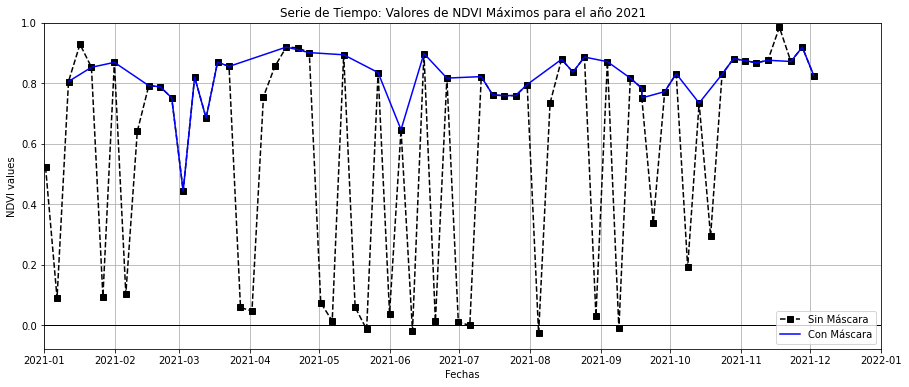

In [ ]:
# Visualización
plt.figure(figsize=(15,6))
plt.plot(df_sin_mask.Timestamp, df_sin_mask.NDVI, 'ks--', label='Sin Máscara')
plt.plot(df_con_mask.Timestamp, df_con_mask.NDVI, 'b-', label='Con Máscara')

# plt.plot(dfs2['Fecha Precisa'], dfs2['Porcentaje Nubes (%)']/100, 'cs-') # Nubosidad en imágenes
plt.title(f'Serie de Tiempo: Valores de NDVI Máximos para el año {year}'), plt.xlabel('Fechas'), plt.ylabel('NDVI values')
plt.xlim(pd.Timestamp('2021'),pd.Timestamp('2022'))
plt.xticks([pd.Timestamp(f'2021-{i}') for i in range(1,13)]+[pd.Timestamp('2022-1')])
plt.gca().xaxis.set_major_formatter(date_format)
plt.ylim(top=1)
plt.legend(loc='lower right')
plt.axhline(0, color = 'black', linewidth = '1') # Resaltar el 0
plt.grid();

In [ ]:
# @markdown Visualización con Altair

base = alt.Chart(df_con_mask).encode(x=alt.X('Timestamp:T'))

points = base.mark_circle(size=60).encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma')),
    tooltip=[
        alt.Tooltip('Timestamp:T', title='Fecha'),
        alt.Tooltip('NDVI:Q', title='NDVI')
    ])

line = base.mark_line().encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma'))
)

(points+line).properties(width=800, height=400).interactive()

alt.LayerChart(...)

In [ ]:
df_ag_dic =  s2_parcelas_df.copy()

## Pruebas

Ojo: 
- Banda SWIR
- https://www.researchgate.net/publication/329134561_Impact_of_different_within-canopy_wind_attenuation_formulations_on_modelling_sensible_heat_flux_using_TSEB


##### Funciones (prueba)

In [ ]:
!wget https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/main/funciones.py

--2021-12-06 19:51:58--  https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/main/funciones.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4033 (3.9K) [text/plain]
Saving to: ‘funciones.py’

funciones.py        100%[===================>]   3.94K  --.-KB/s    in 0s      

2021-12-06 19:51:59 (50.6 MB/s) - ‘funciones.py’ saved [4033/4033]



In [ ]:
from funciones import *
# Dar click al archivo funciones.py para visualizar su contenido o en el link de descarga

##### Pruebas NDVI

In [ ]:
ID_snippet_name = 'COPERNICUS/S2_SR'
year = 2021
roi = chongoyape

## Filtrado de ee.imageCollection
icol_sr = (
    ee.ImageCollection(ID_snippet_name)\
    .filterDate(str(year), str(year+1))\
    .filterBounds(roi)
)

icol_rgb = icol_sr.map(eeImagetoRGB)
icol_ndvi = icol_sr.map(ndvi_icol)
icol_evi = icol_sr.map(evi_icol)

In [ ]:
df = df1

def eeImagetoRGB(image):
  img = ee.Image(image).multiply(0.0001)
  return img

# lista_imgs = df[df['Mes'] == 1]['Sentinel-2 ID'].tolist()
# lista_imgs = lista_imgs.map(eeImagetoRGB)
# lista_imgs

In [ ]:
# @markdown Función `visualizar_mes_S2_SR(mes)`

def visualizar_mes_S2_SR(mes, df, indice):
  
  # Del dataframe obtenemos las imagenes de acuerdo al mes que queramos
  lista_imgs = df[df['Mes'] == mes]['Sentinel-2 ID'].tolist()
  
  imagen_str = lista_imgs[img-1]
  print(f'Fecha: {mes}/{imagen_str[23:25]}')

  imagen_ee = ee.Image(imagen_str)
  imagen_rgb = imagen_ee.multiply(0.0001)

  if indice == 'ndvi':
    imagen_indice = ndvi_icol(imagen_ee)
  elif indice == 'evi':
    imagen_indice = evi_icol(imagen_ee)

  # Visualización
  vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} # 'gamma':1.4
  viz_params = {'min':0, 'max':0.5, 'palette': yuri_ndvi_pal}

  Map = geemap.Map(layer_ctrl=True) # basemap='OpenStreetMap.Mapnik', 
  Map.centerObject(chongoyape, 12)  # Map.setCenter(-79.809, -6.746, 9)

  for i in lista_imgs:
    Map.addLayer(, 
                 vis_rgb, f'RGB {i[21:23]}/{i[23:25]}') # {i} .clip(roiDep)
    Map.addLayer(ndvi_icol(ee.Image(i)), 
                 viz_params, f'NDVI {i[21:23]}/{i[23:25]}') # {i} .clip(roiDep)
 
  # Visualizar al último el distrito de Chongoyape
  Map.addLayer(chongoyape, {'color':'00FF00'}, 'Chongoyape') # roiChongoyapeDraw
  
  return Map

In [ ]:
# df1 = generar_reporte_S2_SR(chongoyape, year=2021)
# mes = df1['Mes'].unique().tolist()

interact(visualizar_mes_S2_SR, mes=mes, df=fixed(df1));

interactive(children=(Dropdown(description='mes', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), value=1), Outpu…

##### Pruebas EVI

In [ ]:
def ver_evi_mensual(mes, img):
  lista_imgs = df1['Sentinel-2 ID'][df1['Mes'] == mes].tolist()
  print(f'Hay {len(lista_imgs)} imágenes en este mes')
  evi = evi_icol(ee.Image(lista_imgs[img-1]))

  # viz_params = {'min':0, 'max':0.5, 'palette': yuri_ndvi_pal}
  ndvi_palette = ["#051852", "#FFFFFF", "#C7B59B", "#A8B255", "#A3C020", "#76AD00","#429001", "#006400", "#003B00", "#000000"]
  viz_params = {'min':0.0, 'max':0.5, 'palette': yuri_ndvi_pal}#ndvi_palette}

  Map = geemap.Map(basemap='OpenStreetMap.Mapnik', layer_ctrl=True)
  Map.centerObject(chongoyape, 12)  # Map.setCenter(-79.809, -6.746, 9)
  Map.addLayer(evi, viz_params, f'EVI {lista_imgs[img-1][21:23]}/{lista_imgs[img-1][23:25]}')
  Map.addLayer(chongoyape, {'color':'00FF00'}, 'Chongoyape') # roiChongoyapeDraw

  return Map

interact(ver_evi_mensual, mes=np.arange(1,12,1), img=(1,7,1));

interactive(children=(Dropdown(description='mes', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), value=1), IntSl…

In [ ]:
evi_mean = evi_icol(ee.Image('COPERNICUS/S2_SR/20211028T153619_20211028T153620_T17MPN'))

viz_params = {'min':-1, 'max':1, 'palette': yuri_ndvi_pal}
# ndvi_palette = ["#051852", "#FFFFFF", "#C7B59B", "#A8B255", "#A3C020", "#76AD00","#429001", "#006400", "#003B00", "#000000"]
# viz_params = {'min':0, 'max':0.5, 'palette': ndvi_palette}

Map = geemap.Map(basemap='OpenStreetMap.Mapnik', layer_ctrl=True)
Map.centerObject(chongoyape, 12)  # Map.setCenter(-79.809, -6.746, 9)
Map.addLayer(evi_mean, viz_params, 'EVI')
Map.addLayer(chongoyape, {'color':'00FF00'}, 'Chongoyape') # roiChongoyapeDraw
Map

Map(center=[-6.639, -79.389], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

In [ ]:
evi_mean = icol_str.map(evi_icol).mean()

viz_params = {'min':0, 'max':0.5, 'palette': yuri_ndvi_pal}
# ndvi_palette = ["#051852", "#FFFFFF", "#C7B59B", "#A8B255", "#A3C020", "#76AD00","#429001", "#006400", "#003B00", "#000000"]
# viz_params = {'min':0, 'max':0.5, 'palette': ndvi_palette}

Map = geemap.Map(basemap='OpenStreetMap.Mapnik', layer_ctrl=True)
Map.centerObject(chongoyape, 12)  # Map.setCenter(-79.809, -6.746, 9)
Map.addLayer(evi_mean, viz_params, 'EVI')
Map.addLayer(chongoyape, {'color':'00FF00'}, 'Chongoyape') # roiChongoyapeDraw
Map

Map(center=[-6.639, -79.389], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

In [ ]:
# ndvi_mean = icol_str.map(ndvi_icol).mean()
ndvi_mean = icol_sr.map(ndvi_icol).first()

ndvi_palette = ["#051852", "#FFFFFF", "#C7B59B", "#A8B255", "#A3C020", "#76AD00","#429001", "#006400", "#003B00", "#000000"]
viz_params = {'min':0, 'max':0.5, 'palette': ndvi_palette}

Map = geemap.Map(basemap='OpenStreetMap.Mapnik', layer_ctrl=True)
Map.centerObject(chongoyape, 12)  # Map.setCenter(-79.809, -6.746, 9)
Map.addLayer(ndvi_mean, viz_params, 'NDVI')
Map.addLayer(chongoyape, {'color':'00FF00'}, 'Chongoyape') # roiChongoyapeDraw
Map

Map(center=[-6.639, -79.389], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

##### Aplicación de Remoción de Nubes

Aplicando dataset [Sentinel-2: Cloud Probability](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_CLOUD_PROBABILITY) 
- Tutorial: Google Earth Engine/Community/Tutorials/Python Tutorials/[Sentinel-2 Cloud Masking with s2cloudless](https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless)

Arroz - Campañas de siembra a cosecha: **Agosto a Diciembre**

Imágenes libre de nubes:
- Agosto: 9, 14, 19, 24
- Setiembre: 3, 13, 18 (problema de corte), 28
- Octubre: 23 y 28
- Noviembre: 2, 7, 17, 22 y 27


In [ ]:
AOI = chongoyape_punto

year = 2021
month = 8
day = 19
fecha = f'{year}-{month}-{day}'
START_DATE = ee.Date(fecha)
END_DATE = START_DATE.advance(1, 'day')

CLOUD_FILTER = 60
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50

roi_clip = chongoyape #area_total.geometry().bounds()

######  Funciones 1

In [ ]:
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

In [ ]:
s2_sr_cld_col_eval = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

In [ ]:
def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability').clip(roi_clip)

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

In [ ]:
def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6).clip(roi_clip)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels').clip(roi_clip)

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform')).clip(roi_clip)

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

In [ ]:
def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focal_min(2).focal_max(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

In [ ]:
# Import the folium library.
import folium

# Define a method for displaying Earth Engine image tiles to a folium map.
def add_ee_layer(self, ee_image_object, vis_params, name, show=True, opacity=1, min_zoom=0):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        show=show,
        opacity=opacity,
        min_zoom=min_zoom,
        overlay=True,
        control=True
        ).add_to(self)

# Add the Earth Engine layer method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [ ]:
def display_cloud_layers(col):
    # Mosaic the image collection.
    img = col.mosaic().clip(roi_clip)

    # Subset layers and prepare them for display.
    clouds = img.select('clouds').selfMask()
    shadows = img.select('shadows').selfMask()
    dark_pixels = img.select('dark_pixels').selfMask()
    probability = img.select('probability')
    cloudmask = img.select('cloudmask').selfMask()
    cloud_transform = img.select('cloud_transform')

    # Create a folium map object.
    center = AOI.centroid(10).coordinates().reverse().getInfo()
    m = folium.Map(location=center, zoom_start=12, height=700)

    # Add layers to the folium map.
    m.add_ee_layer(img,
                   {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
                   'S2 image', True, 1, 9)
    m.add_ee_layer(probability,
                   {'min': 0, 'max': 100},
                   'probability (cloud)', False, 1, 9)
    m.add_ee_layer(clouds,
                   {'palette': 'e056fd'},
                   'clouds', False, 1, 9)
    m.add_ee_layer(cloud_transform,
                   {'min': 0, 'max': 1, 'palette': ['white', 'black']},
                   'cloud_transform', False, 1, 9)
    m.add_ee_layer(dark_pixels,
                   {'palette': 'orange'},
                   'dark_pixels', False, 1, 9)
    m.add_ee_layer(shadows, {'palette': 'yellow'},
                   'shadows', False, 1, 9)
    m.add_ee_layer(cloudmask, {'palette': 'orange'},
                   'cloudmask', True, 0.5, 9)

    # Add a layer control panel to the map.
    m.add_child(folium.LayerControl())

    # Display the map.
    display(m)

###### Visualización 1

In [ ]:
s2_sr_cld_col_eval_disp = s2_sr_cld_col_eval.map(add_cld_shdw_mask)

display_cloud_layers(s2_sr_cld_col_eval_disp)

###### Funciones 2

In [ ]:
def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

In [ ]:
s2_sr_cld_col = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

In [ ]:
s2_sr_median = (s2_sr_cld_col.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask)
                             .median())

###### Visualización 2

In [ ]:
# @markdown ##### Visualización 2
# Create a folium map object.
center = AOI.centroid(10).coordinates().reverse().getInfo()
m = folium.Map(location=center, zoom_start=12, height=700)

# Add layers to the folium map.
m.add_ee_layer(s2_sr_median,
                {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
                'S2 cloud-free mosaic', True, 1, 9)

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)

##### Prueba

In [ ]:
df = reporteL8_C2.copy()

In [ ]:
imgs = {}
for i in range(8,12):
  imgs[i]=df[df['Mes']==i]['ID GEE'].tolist()

imgs

{8: ['LANDSAT/LC08/C02/T1_L2/LC08_010065_20210814',
  'LANDSAT/LC08/C02/T1_L2/LC08_010065_20210830'],
 9: ['LANDSAT/LC08/C02/T1_L2/LC08_010065_20210915'],
 10: ['LANDSAT/LC08/C02/T1_L2/LC08_010065_20211001',
  'LANDSAT/LC08/C02/T1_L2/LC08_010065_20211017'],
 11: ['LANDSAT/LC08/C02/T1_L2/LC08_010065_20211102',
  'LANDSAT/LC08/C02/T1_L2/LC08_010065_20211118']}

In [ ]:
df[df['Mes']==9]['ID GEE']#.tolist()

14    LANDSAT/LC08/C02/T1_L2/LC08_010065_20210915
Name: ID GEE, dtype: object

## Balance de Energía Superficial - Modelo METRIC

- METRIC (2007) se realizó con imágenes Landsat 7 ETM+ y Landsat 8 empezó a operar en 2013.

### Ecuación del Balance de energía

\

$$
LE = R_n - G - H
$$

Dónde: 
- $LE$ : Energía latente consumida por ET $[W/m²]$
- $R_n$ : Radiación neta (suma de todas las radiaciones de onda corta y larga, sean entrantes o salientes a la superficie) $[W/m²]$
- $G$ : Flujo de calor sensible conducido al suelo $[W/m²]$
- $H$ : Flujo de calor sensible convectado al aire $[W/m²]$

\

### Radiación Neta / Net Radiation $R_n$

Morse et al. 2000:

$$
R_n = (1- \alpha)R_{S\downarrow} + (R_{L\downarrow} - R_{L\uparrow}) - (1- \epsilon_0)R_{L\downarrow}
$$

Dónde: 
- $R_n$ : Flujo de radiación neta $[W/m^2]$
- $\alpha$ : Albedo de superficie
- $R_{S\downarrow}$ : Radiación de onda corta entrante $[W/m^2]$
- $R_{L\downarrow}$ : Radiación de onda larga entrante $[W/m^2]$
- $R_{L\uparrow}$ : Radiación de onda larga saliente $[W/m^2]$
- $\epsilon_0$ : Emisividad del ancho de banda en la superficie / broad-band surface thermal emissivity

The $(1- \epsilon_0)R_{L\downarrow}$ term represents the fraction of incoming long-wave
radiation reflected from the surface.

#### Albedo / Surface Albedo $\alpha_{s}$

METRIC

- Usa imágenes Landsat 7 ETM+

#### Radiación de onda corta entrante / Incoming Solar Radiation $R_{S\downarrow}$ 

<img src='https://www.aulafacil.com/uploads/cursos/5922/20208_angulos-y-altura-en-la-trayectoria-del-sol.es.jpg' width='50%'/>

#### Radiación de onda larga saliente / Outgoing Long-Wave Radiation $R_{L\uparrow}$ 

#### Radiación de onda larga entrante / Incoming Long-Wave Radiation $R_{L\downarrow}$

### Flujo de calor del suelo / Soil Heat Flux $G$

### Flujo de calor sensible / Sensible Heat Flux $H$

### $\lambda{ET}$ y $ET$ instantánea

### Evapotranspiración de cultivo $ET_c$ por día